In [3]:
import torch
import rasterio
import numpy as np

In [5]:
from pathlib import Path

DATASET_DIR = Path("datasets")
BUILDING_DATASET_DIR = DATASET_DIR / "building_footprints"
SENTINEL_DATASET_DIR = DATASET_DIR / "sentinel"

In [24]:
from matplotlib import pyplot as plt

def vis(img):
    masked_data = np.ma.masked_equal(img, 0)
    lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
    data = np.clip(img, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)

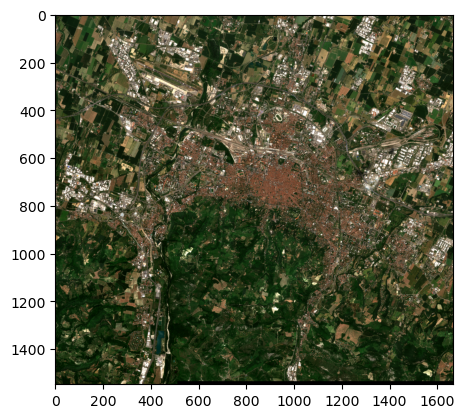

In [80]:
with rasterio.open(SENTINEL_DATASET_DIR / "R.tiff") as f:
    r_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "G.tiff") as f:
    g_data = np.transpose(f.read(), (1,2,0)).squeeze()    
with rasterio.open(SENTINEL_DATASET_DIR / "B.tiff") as f:
    b_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "IR.tiff") as f:
    ir_data = np.transpose(f.read(), (1,2,0)).squeeze()

all_bands = np.stack([r_data, g_data, b_data, ir_data], axis=-1)
image_tensor = torch.from_numpy(all_bands)
vis(all_bands[:,:,:3])

In [74]:
image_tensor.size()

torch.Size([1548, 1665, 4])

In [93]:
masked_data = np.ma.masked_equal(image_tensor, 0)
lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
image_norm = np.clip(image_tensor, a_min=lq, a_max=uq)
image_norm = (image_norm - lq) / (uq - lq)
image_height, image_width = image_norm.size()[:2]
image_height, image_width


(1548, 1665)

torch.Size([48, 52, 32, 32, 4])
torch.Size([2496, 32, 32, 4])


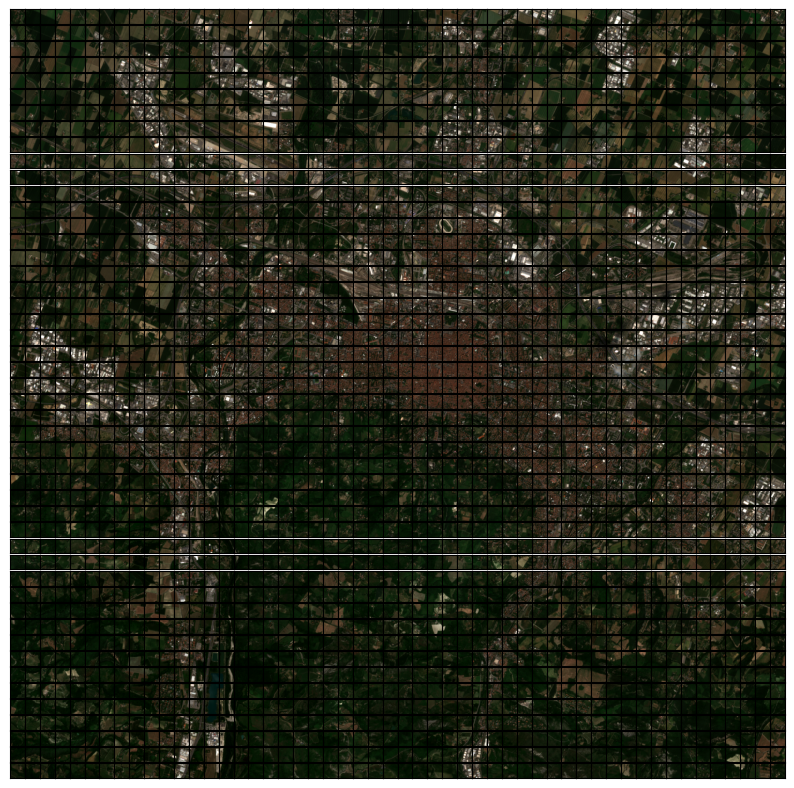

In [106]:
patch_size = 32

patches_grid = image_norm.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size).permute(0,1,3,4,2)
patches_num_x, patches_num_y = patches_grid.size()[:2]
print(patches_grid.size())
patches = patches_grid.flatten(start_dim=0, end_dim=1)
print(patches.size())

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)


for x in range(patches_num_x):
    for y in range(patches_num_y):
        ax = plt.subplot(patches_num_x, patches_num_y, x*patches_num_y + y + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis("off")
        
        patch_rgb = patches_grid[x, y, :, :, :3]
        plt.imshow(patch_rgb)

torch.Size([48, 52, 32, 32, 4])


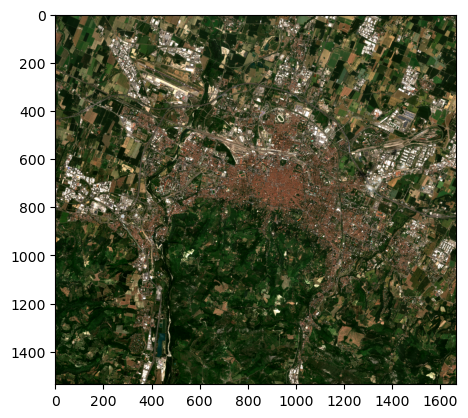

In [104]:
# Test reconstruction
patches_grid_recon = patches.view(patches_num_x, patches_num_y, patch_size, patch_size, 4)
patches_grid_recon = patches_grid_recon.permute(0, 2, 1, 3, 4).contiguous()
patches_grid_recon = patches_grid_recon.view(patches_num_x * patch_size, patches_num_y * patch_size, 4)

print(patches_grid_recon.size())
vis(patches_grid_recon[:,:,:3])

In [118]:
def is_cloud_present(patch):
    # TODO
    return False

valid_patches = []
for i in range(len(patches)):
    if not is_cloud_present(patches[i]):
        valid_patches.append(i)

torch.Size([2496, 32, 32, 4])


In [116]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(patches[valid_patches, :, :, :])

In [117]:
generator = torch.Generator().manual_seed(42)
train, test, val = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=generator)
len(train), len(test), len(val)

(1498, 499, 499)